# **Mengelompokan dataset e-commerce dengan Clustering KMeans**

In [1]:
!pip install pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import silhouette_score
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator



# **Step 1: Load Data**

In [3]:
data = pd.read_csv('olist_customers_dataset.csv')
data.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  payment_sequential payment_type  ...  \
0           2017-10-18 00:00:00                   1  credit_card  ...   
1           2017-10-18 00:00:00                   3      voucher  ...   
2           2017-10-18 00:00:00                   2      voucher  ...   
3           2017-08-28 00:00:00                   1  credit_card  ...   
4           2017-08-15 00:00:00                   1  credit_card  ...   

   product_name_lenght  product_description_lenght product_photos_qty  \
0                 40.0                       268.0                4.0   
1                 40.0                       268.0                4.0   
2                 40.0                       268.0                4.0   
3                 40.0                       268.0                4.0   
4                 40.0                       268.0                4.0   

   product_weight_g product_length_cm product_height_cm  product_width_cm  \
0             500.0              19.0               8.0              13.0   
1             500.0              19.0               8.0              13.0   
2             500.0              19.0               8.0              13.0   
3             500.0              19.0               8.0              13.0   
4             500.0              19.0               8.0              13.0   

  product_category_name_english review_score  \
0                    housewares            4   
1                    housewares            4   
2                    housewares            4   
3                    housewares            4   
4                    housewares            5   

                              review_comment_message  
0  Não testei o produto ainda, mas ele veio corre...  
1  Não testei o produto ainda, mas ele veio corre...  
2  Não testei o produto ainda, mas ele veio corre...  
3  Deveriam embalar melhor o produto. A caixa vei...  
4  Só achei ela pequena pra seis xícaras ,mais é ...  

[5 rows x 33 columns]

In [4]:
#melihat bentuk dari dataset
rows, column = data.shape
print('Dataset berisi', rows, 'baris dan', column, 'kolom.')

Dataset berisi 115609 baris dan 33 kolom.


In [5]:
#melihat tipe setiap kolom
print('Tipe data tiap kolom: \n')
data.info()

Tipe data tiap kolom: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   payment_sequential             115609 non-null  int64  
 9   payment_type                   115609 non-null  object 
 10  payment_installments           115609 non-null  int64  
 11  payment_value                  115609 non-null  float64
 12  custom

In [6]:
#Descriptive Statistics
data.describe().T

count          mean           std      min  \
payment_sequential          115609.0      1.093747      0.729849     1.00   
payment_installments        115609.0      2.946233      2.781087     0.00   
payment_value               115609.0    172.387379    265.873969     0.00   
customer_zip_code_prefix    115609.0  35061.537597  29841.671732  1003.00   
order_item_id               115609.0      1.194535      0.685926     1.00   
price                       115609.0    120.619850    182.653476     0.85   
freight_value               115609.0     20.056880     15.836184     0.00   
product_name_lenght         115609.0     48.766541     10.034187     5.00   
product_description_lenght  115609.0    785.808198    652.418619     4.00   
product_photos_qty          115609.0      2.205373      1.717771     1.00   
product_weight_g            115608.0   2113.907697   3781.754895     0.00   
product_length_cm           115608.0     30.307903     16.211108     7.00   
product_height_cm           115608.0     16.638477     13.473570     2.00   
product_width_cm            115608.0     23.113167     11.755083     6.00   
review_score                115609.0      4.034409      1.385584     1.00   

                                 25%       50%       75%       max  
payment_sequential              1.00      1.00      1.00     29.00  
payment_installments            1.00      2.00      4.00     24.00  
payment_value                  60.87    108.05    189.48  13664.08  
customer_zip_code_prefix    11310.00  24241.00  58745.00  99980.00  
order_item_id                   1.00      1.00      1.00     21.00  
price                          39.90     74.90    134.90   6735.00  
freight_value                  13.08     16.32     21.21    409.68  
product_name_lenght            42.00     52.00     57.00     76.00  
product_description_lenght    346.00    600.00    983.00   3992.00  
product_photos_qty              1.00      1.00      3.00     20.00  
product_weight_g              300.00    700.00   1800.00  40425.00  
product_length_cm              18.00     25.00     38.00    105.00  
product_height_cm               8.00     13.00     20.00    105.00  
product_width_cm               15.00     20.00     30.00    118.00  
review_score                    4.00      5.00      5.00      5.00

In [7]:
#menyalin data untuk mempertahankan data asli
df = data.copy(deep = True)

In [8]:
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  payment_sequential payment_type  ...  \
0           2017-10-18 00:00:00                   1  credit_card  ...   
1           2017-10-18 00:00:00                   3      voucher  ...   
2           2017-10-18 00:00:00                   2      voucher  ...   
3           2017-08-28 00:00:00                   1  credit_card  ...   
4           2017-08-15 00:00:00                   1  credit_card  ...   

   product_name_lenght  product_description_lenght product_photos_qty  \
0                 40.0                       268.0                4.0   
1                 40.0                       268.0                4.0   
2                 40.0                       268.0                4.0   
3                 40.0                       268.0                4.0   
4                 40.0                       268.0                4.0   

   product_weight_g product_length_cm product_height_cm  product_width_cm  \
0             500.0              19.0               8.0              13.0   
1             500.0              19.0               8.0              13.0   
2             500.0              19.0               8.0              13.0   
3             500.0              19.0               8.0              13.0   
4             500.0              19.0               8.0              13.0   

  product_category_name_english review_score  \
0                    housewares            4   
1                    housewares            4   
2                    housewares            4   
3                    housewares            4   
4                    housewares            5   

                              review_comment_message  
0  Não testei o produto ainda, mas ele veio corre...  
1  Não testei o produto ainda, mas ele veio corre...  
2  Não testei o produto ainda, mas ele veio corre...  
3  Deveriam embalar melhor o produto. A caixa vei...  
4  Só achei ela pequena pra seis xícaras ,mais é ...  

[5 rows x 33 columns]

# **Step 2: Feature Selection**

Tipe kolom yg akan di-drop atau di-hapus:
*   Kolom yang tidak berkontribusi pada proses clustering.
*   Kolom non-numerik yang tidak dapat langsung digunakan tanpa pengkodean.
*   Kolom dengan terlalu banyak nilai yang hilang.
*   Kolom yang merupakan stempel waktu, kecuali Anda mengekstrak fitur yang berarti dari kolom tersebut.

In [9]:
columns_to_drop = [
    'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date',
    'payment_type', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state',
    'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'product_category_name',
    'product_category_name_english', 'review_comment_message'
]

df = df.drop(columns=columns_to_drop)

In [10]:
df.head()

payment_sequential  payment_installments  payment_value  price  \
0                   1                     1          18.12  29.99   
1                   3                     1           2.00  29.99   
2                   2                     1          18.59  29.99   
3                   1                     3          37.77  29.99   
4                   1                     1          37.77  29.99   

   freight_value  product_name_lenght  product_description_lenght  \
0           8.72                 40.0                       268.0   
1           8.72                 40.0                       268.0   
2           8.72                 40.0                       268.0   
3           7.78                 40.0                       268.0   
4           7.78                 40.0                       268.0   

   product_photos_qty  product_weight_g  product_length_cm  product_height_cm  \
0                 4.0             500.0               19.0                8.0   
1                 4.0             500.0               19.0                8.0   
2                 4.0             500.0               19.0                8.0   
3                 4.0             500.0               19.0                8.0   
4                 4.0             500.0               19.0                8.0   

   product_width_cm  review_score  
0              13.0             4  
1              13.0             4  
2              13.0             4  
3              13.0             4  
4              13.0             5

In [11]:
#melihat bentuk dari dataset
rows, column = df.shape
print('Dataset berisi', rows, 'baris dan', column, 'kolom.')

Dataset berisi 115609 baris dan 13 kolom.


Text(0.5, 1.0, 'Correlation Matrix')

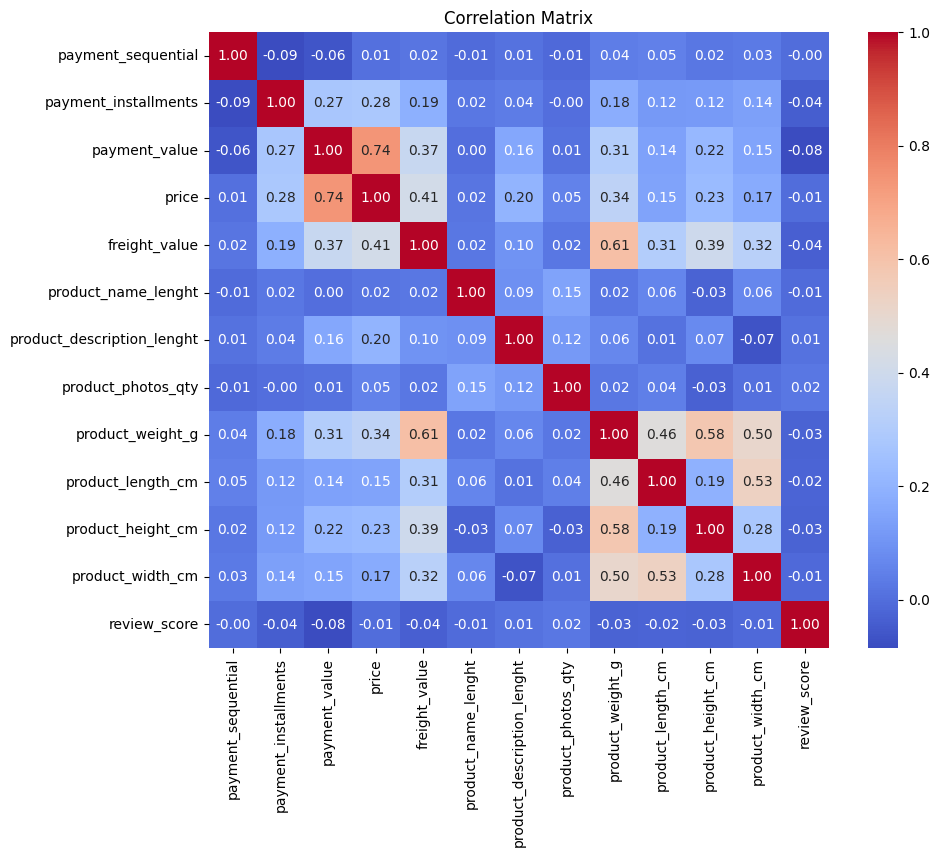

In [12]:
# Calculate correlation matrix for numeric columns
corr_matrix = df.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# **Step 3: Data Preprocessing**

# Deteksi data duplikat dan hapus

In [13]:
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 18321


In [14]:
# hapus duplikat
df.drop_duplicates(inplace=True)

# cek duplikat lagi
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


# Deteksi nilai kosong dan menggantinya dengan median

In [15]:
# mendefinisikan list indikator nilai kosong
missing_value_indicators = ['?', 'Unknown', 'N/A', 'NA', 'NULL', '', '9999', 'TBD', 'MISSING']

# menggantinya dengan NaN
df.replace(missing_value_indicators, np.nan, inplace=True)

NaN untuk numeric
 None untuk category

In [16]:
#cek nilai kosong
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 payment_sequential            0
payment_installments          0
payment_value                 0
price                         0
freight_value                 0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              1
product_length_cm             1
product_height_cm             1
product_width_cm              1
review_score                  0
dtype: int64


In [17]:
# mengisi nilai kosong (NaN) dengan median
df.fillna(df.median(numeric_only=True), inplace=True)

# cek nilai kosong lagi
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 payment_sequential            0
payment_installments          0
payment_value                 0
price                         0
freight_value                 0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
review_score                  0
dtype: int64


# Deteksi outlier dengan Z-scores dan menghapusnya

In [18]:
from scipy import stats

# deteksi outlier dengan Z-score
z_scores = np.abs(stats.zscore(df))
threshold = 3
outlier_indices = np.where(z_scores > threshold)
outliers = df.iloc[outlier_indices[0], :]

print("Outliers:")
print(outliers)

Outliers:
        payment_sequential  payment_installments  payment_value  price  \
6                        1                    10         356.12  339.0   
17                       1                     2         172.14  160.0   
18                       1                     1         162.03  139.0   
19                       1                     1         183.92  160.0   
20                       2                     1         150.00  160.0   
...                    ...                   ...            ...    ...   
115570                   1                     5         350.54  329.0   
115571                   1                     1         344.32  329.0   
115572                   1                    10         350.54  329.0   
115586                   1                     1         306.72  238.0   
115586                   1                     1         306.72  238.0   

        freight_value  product_name_lenght  product_description_lenght  \
6               17.12      

In [19]:
# hapus outlier
df = df[(z_scores < threshold).all(axis=1)]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84323 entries, 0 to 115608
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   payment_sequential          84323 non-null  int64  
 1   payment_installments        84323 non-null  int64  
 2   payment_value               84323 non-null  float64
 3   price                       84323 non-null  float64
 4   freight_value               84323 non-null  float64
 5   product_name_lenght         84323 non-null  float64
 6   product_description_lenght  84323 non-null  float64
 7   product_photos_qty          84323 non-null  float64
 8   product_weight_g            84323 non-null  float64
 9   product_length_cm           84323 non-null  float64
 10  product_height_cm           84323 non-null  float64
 11  product_width_cm            84323 non-null  float64
 12  review_score                84323 non-null  int64  
dtypes: float64(10), int64(3)
memory usa

# **Step 4: Feature Scaling**

In [21]:
from pyspark.sql import SparkSession
# Start Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# konversi Pandas DataFrame ke PySpark DataFrame
df_spark = spark.createDataFrame(df)

In [22]:
# mendefinisikan tahap assembler, scaler, dan PCA
assembler = VectorAssembler(inputCols=df_spark.columns, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# cari k terbaik untuk pca
pca = PCA(k=len(df_spark.columns), inputCol="scaled_features", outputCol="pca_features")


# **Step 5: Buat Model**

In [23]:
# membuat  pipeline
pipeline_obj = Pipeline(stages=[assembler, scaler, pca])

# mencocokan dan merubah data
pipeline_model = pipeline_obj.fit(df_spark)
transformed_data = pipeline_model.transform(df_spark)

In [24]:
# mencari k pca
explained_variance_ratios = pipeline_model.stages[-1].explainedVariance

cumulative_variance = np.cumsum(explained_variance_ratios)

optimal_k = np.argmax(cumulative_variance >= 0.95) + 1

print("Optimal k:", optimal_k)

Optimal k: 11


In [25]:
# update PCA dengan k optimal
pca = PCA(k=optimal_k, inputCol="scaled_features", outputCol="pca_features")

pipeline_obj = Pipeline(stages=[assembler, scaler, pca])

# mencocokan dan merubah data dengan tahap terbaru
pipeline_model = pipeline_obj.fit(df_spark)
transformed_data = pipeline_model.transform(df_spark)

In [26]:
# Show the first 10 rows of the DataFrame
transformed_data.show(10, truncate=False)

+------------------+--------------------+-------------+-----+-------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|payment_sequential|payment_installments|payment_value|price|freight_value|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|review_score|features          

# **Step 6: Mencari nilai k terbaik**

In [27]:
# menggunakan
silhouette_scores = []

for k in range(2, 12):
    kmeans = KMeans().setK(k).setSeed(111)
    model = kmeans.fit(transformed_data)
    predictions = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette_score))

# Display all silhouette scores
print("Silhouette Scores for Different k:")
for k, score in silhouette_scores:
    print("k={}, Silhouette Score={}".format(k, score))


Silhouette Scores for Different k:
k=2, Silhouette Score=0.9221345218033989
k=3, Silhouette Score=0.81545716958692
k=4, Silhouette Score=0.5664193524527805
k=5, Silhouette Score=0.6019981678241073
k=6, Silhouette Score=0.6453454064052805
k=7, Silhouette Score=0.6410235578222969
k=8, Silhouette Score=0.6312417097288355
k=9, Silhouette Score=0.6205567388913561
k=10, Silhouette Score=0.552619179111868
k=11, Silhouette Score=0.5272472860695768


In [28]:
# Choose the k with the highest silhouette score
best_k_silhouette = max(silhouette_scores, key=lambda x: x[1])[0]
print("Best k based on silhouette score:", best_k_silhouette)

Best k based on silhouette score: 2


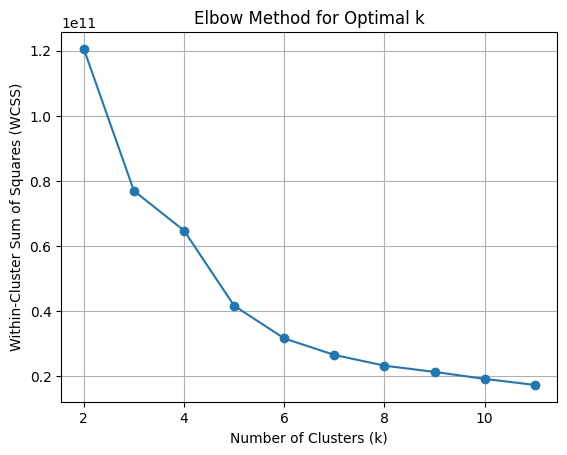

In [29]:
# Fit K-means with different k values and calculate WCSS
wcss = []

for k in range(2, 12):
    kmeans = KMeans().setK(k).setSeed(111)
    model = kmeans.fit(transformed_data)
    wcss.append(model.summary.trainingCost)

# Plot WCSS vs. k
plt.plot(range(2, 12), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# **Step 7: Clustering**

In [30]:
# mencocokan K-means dengan k optimal
kmeans = KMeans().setK(7).setSeed(111)
model = kmeans.fit(transformed_data)

cluster_centers = model.clusterCenters()

# menetapkan setiap titik data ke sebuah cluster
predictions = model.transform(transformed_data)

# **Step 8: Interpretasi**

In [31]:
# menampilkan prediksi cluster untuk setiap titik data
predictions.show(10, truncate=False)

+------------------+--------------------+-------------+-----+-------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|payment_sequential|payment_installments|payment_value|price|freight_value|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|review_score|feature

In [32]:
predictions = predictions.withColumn("prediction", (predictions["prediction"] + 1))
predictions.show(10, truncate=False)

+------------------+--------------------+-------------+-----+-------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------+-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|payment_sequential|payment_installments|payment_value|price|freight_value|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|review_score|feature

In [33]:
from pyspark.sql.functions import count
# Melakukan pengelompokan berdasarkan nilai di dalam kolom 'prediction' dan menghitung jumlah baris untuk setiap grup
grouped_counts = predictions.groupBy('prediction').agg(count('*').alias('count'))

# Menampilkan jumlah baris untuk setiap grup
grouped_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|42334|
|         6| 3875|
|         3| 6412|
|         5| 1209|
|         4|11034|
|         7|17257|
|         2| 2202|
+----------+-----+



# **Step 9: Visualisasi**

In [34]:
# contoh untuk memfilter setiap klaster
cluster_1_data = predictions.filter(predictions['prediction'] == 1).toPandas()
cluster_2_data = predictions.filter(predictions['prediction'] == 2).toPandas()

# memilih kolom
columns_about_payments = [
    'payment_sequential', 'payment_installments', 'payment_value', 'price',
    'freight_value'
]
columns_about_products = [
    'product_name_lenght', 'product_description_lenght',
    'product_photos_qty', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm'
]

# Cluster 1



*   columns_about_payments




Text(0.5, 1.02, 'Pair Plot for Cluster 1 with Review Score as Hue')

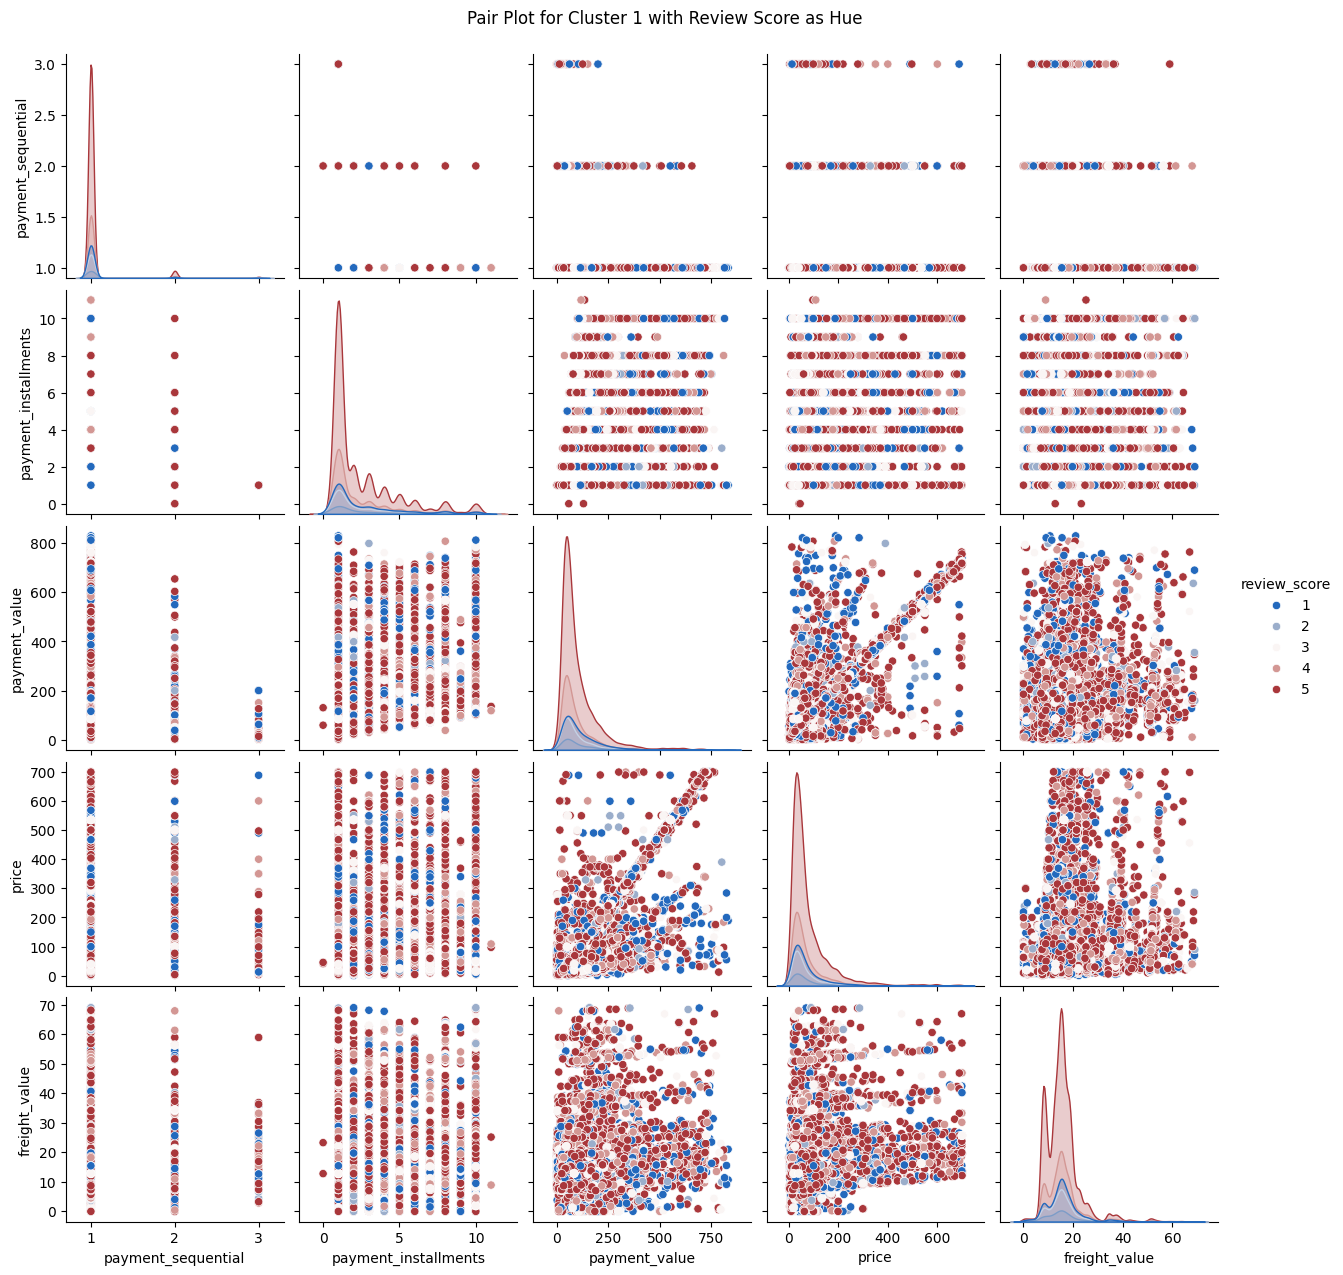

In [35]:
# Filter data
cluster_1_data_to_plot = cluster_1_data[columns_about_payments + ['review_score']]

# Buat pairplot dengan hue disetel ke 'review_score'
sns.pairplot(cluster_1_data_to_plot, hue='review_score', palette='vlag')
plt.suptitle('Pair Plot for Cluster 1 with Review Score as Hue', y=1.02)

Text(0.5, 1.02, 'Scatter Plot Matrix for Cluster 1 with Review Score as Hue')

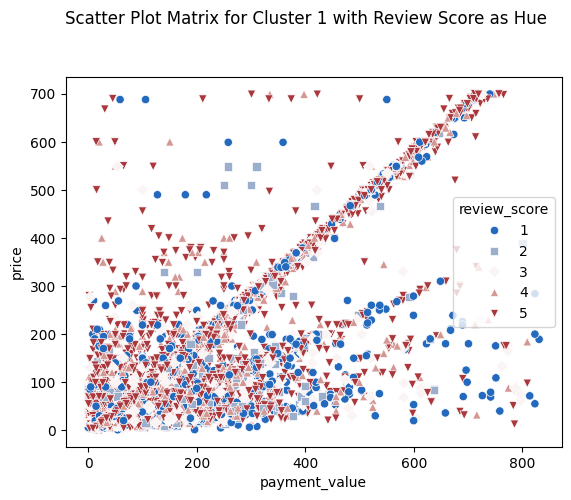

In [36]:
# scatter plot matrix
sns.scatterplot(data=cluster_1_data_to_plot, x=cluster_1_data['payment_value'], y=cluster_1_data['price'], hue='review_score', style='review_score',markers=["o", "s", "D", "^", "v"], palette='vlag')
plt.suptitle('Scatter Plot Matrix for Cluster 1 with Review Score as Hue', y=1.02)

Text(0, 0.5, 'Price')

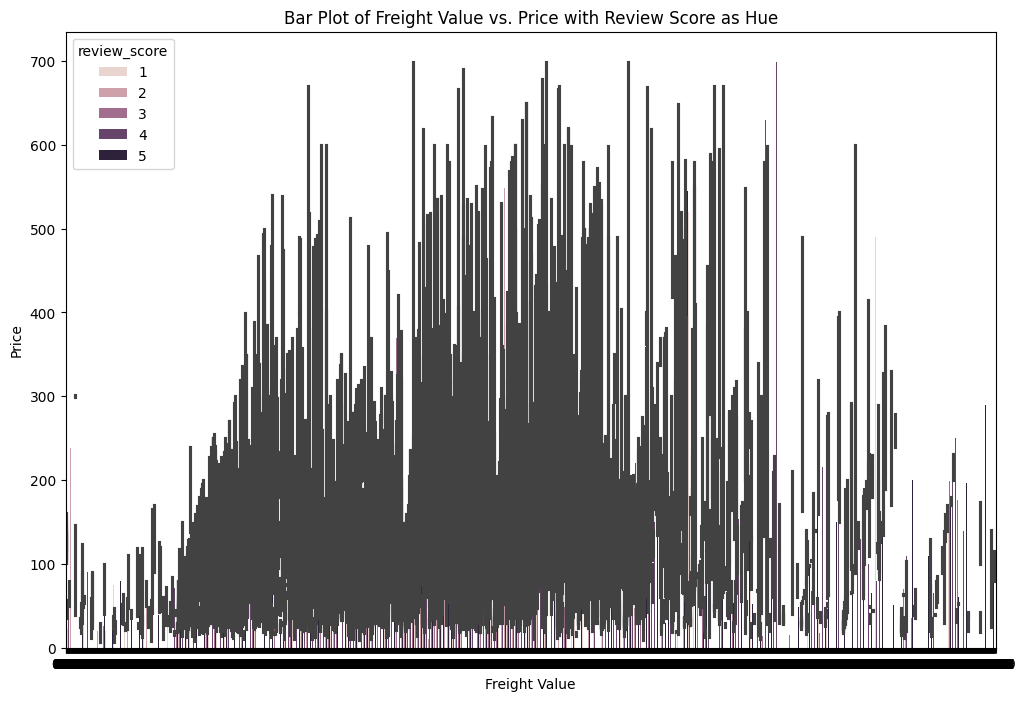

In [37]:
# bar plot matrix
plt.figure(figsize=(12, 8))
sns.barplot(x=cluster_1_data["freight_value"], y=cluster_1_data["price"], hue="review_score", data=cluster_1_data)
plt.title('Bar Plot of Freight Value vs. Price with Review Score as Hue')
plt.xlabel('Freight Value')
plt.ylabel('Price')



*   columns_about_products




Text(0.5, 1.02, 'Pair Plot for Cluster 1 with Review Score as Hue')

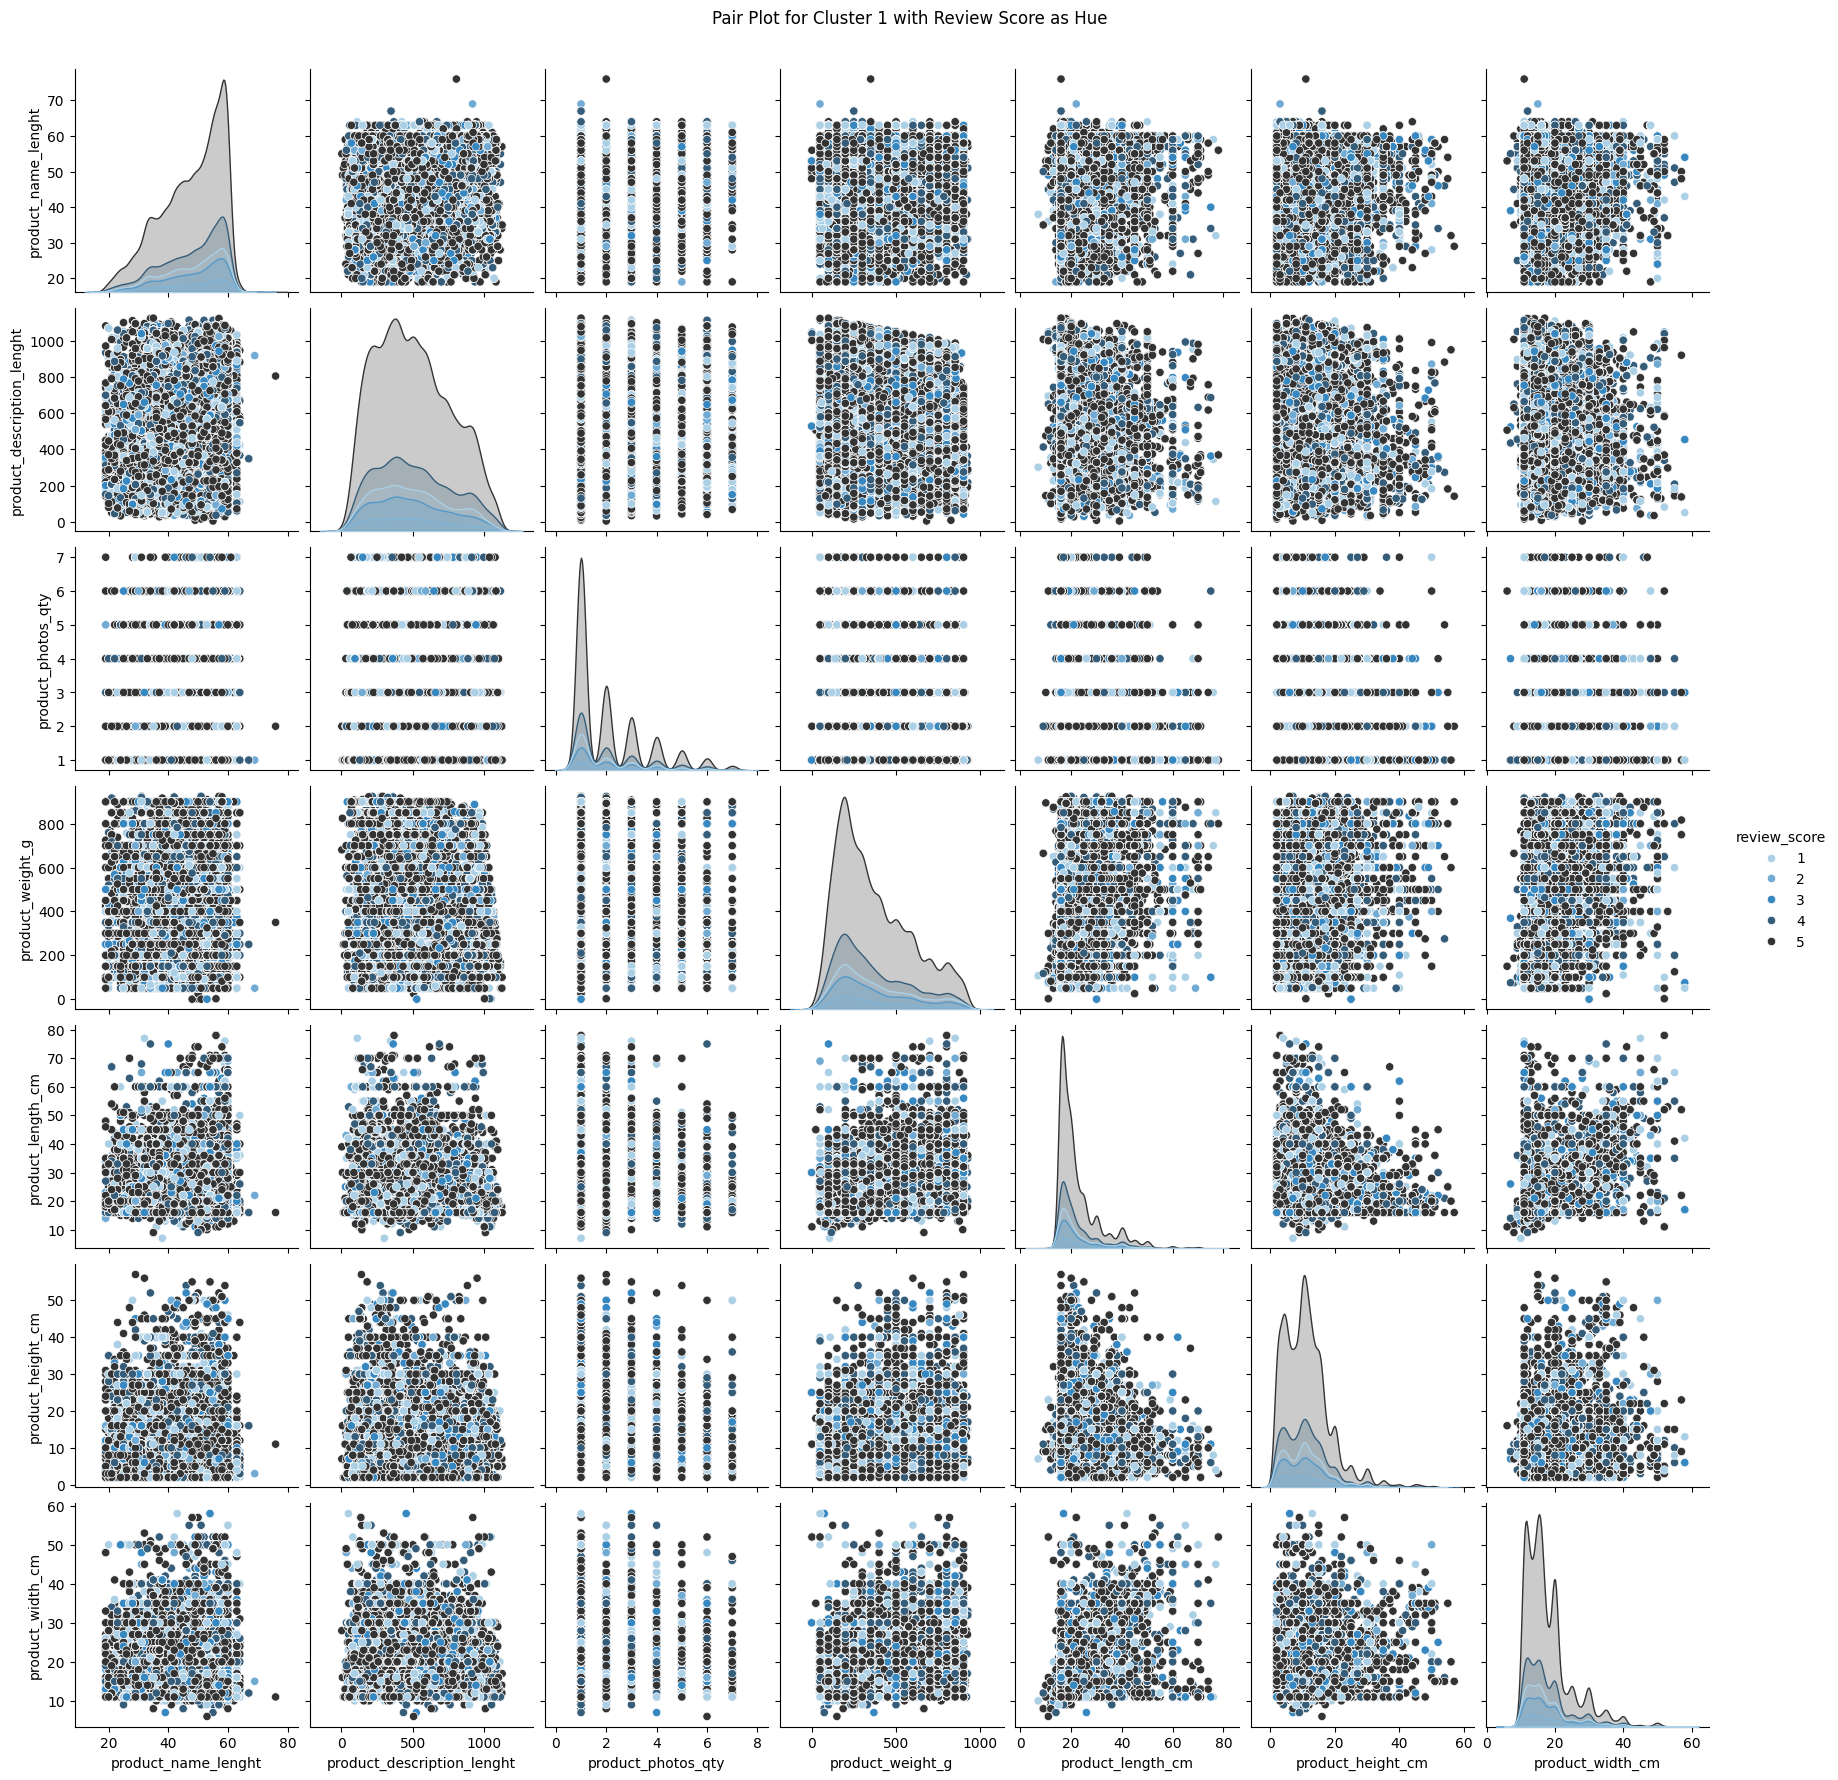

In [38]:
# Filter data
cluster_1_data_to_plot = cluster_1_data[columns_about_products + ['review_score']]

# Buat pairplot dengan hue disetel ke 'review_score'
sns.pairplot(cluster_1_data_to_plot, hue='review_score', palette='Blues_d')
plt.suptitle('Pair Plot for Cluster 1 with Review Score as Hue', y=1.02)

Text(0.5, 1.02, 'Scatter Plot Matrix for Cluster 1 with Review Score as Hue')

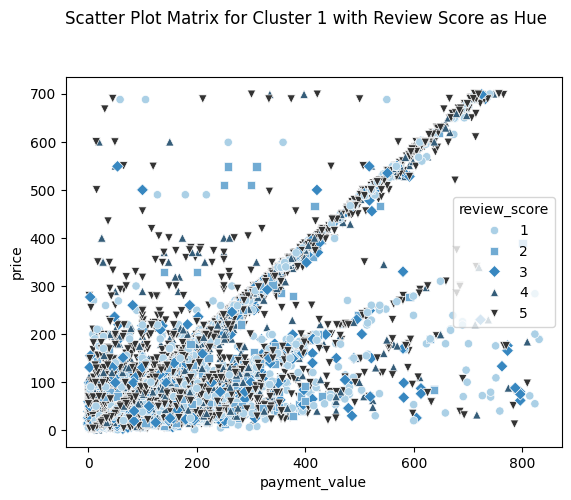

In [39]:

# scatter plot matrix
sns.scatterplot(data=cluster_1_data_to_plot, x=cluster_1_data['payment_value'], y=cluster_1_data['price'], hue='review_score', style='review_score',markers=["o", "s", "D", "^", "v"], palette='Blues_d')
plt.suptitle('Scatter Plot Matrix for Cluster 1 with Review Score as Hue', y=1.02)

# Cluster 2



*   columns_about_payments




Text(0.5, 1.02, 'Pair Plot for Cluster 1 with Review Score as Hue (payments)')

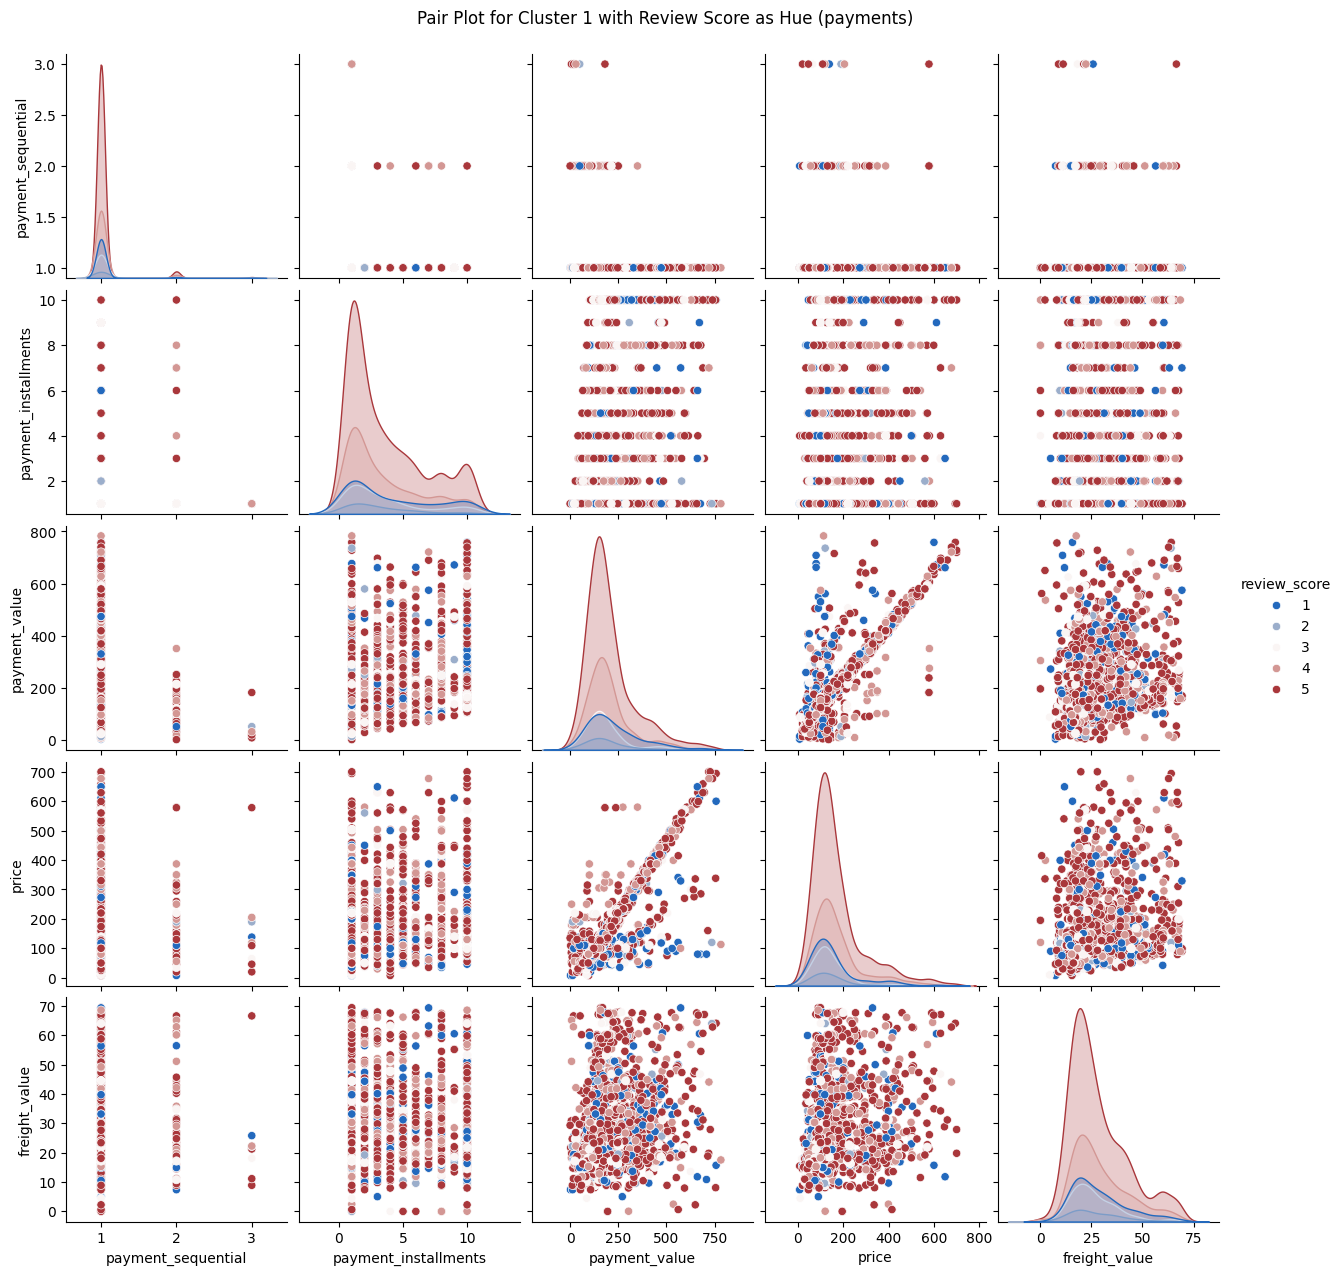

In [40]:
# Filter data for Cluster 1 with selected columns
cluster_2_data_to_plot = cluster_2_data[columns_about_payments + ['review_score']]

# Create a pair plot with hue set to 'review_score'
sns.pairplot(cluster_2_data_to_plot, hue='review_score', palette='vlag')
plt.suptitle('Pair Plot for Cluster 1 with Review Score as Hue (payments)', y=1.02)

Text(0.5, 1.02, 'Scatter Plot Matrix for Cluster 2 with Review Score as Hue (payments)')

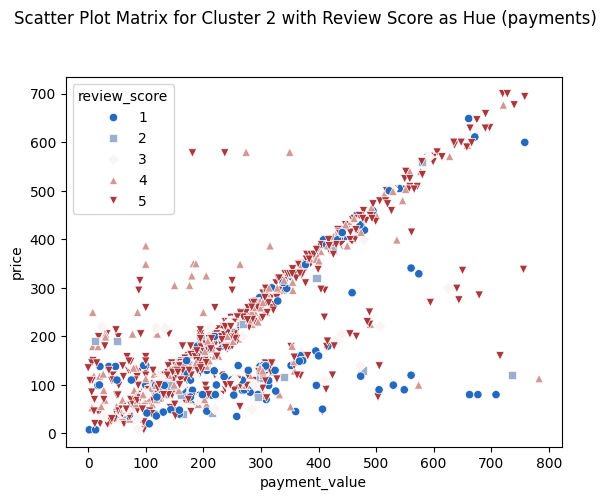

In [41]:
# scatter plot matrix
sns.scatterplot(data=cluster_2_data_to_plot, x=cluster_2_data['payment_value'], y=cluster_2_data['price'], hue='review_score', style='review_score', markers=["o", "s", "D", "^", "v"], palette='vlag')
plt.suptitle('Scatter Plot Matrix for Cluster 2 with Review Score as Hue (payments)', y=1.02)


Text(0, 0.5, 'Price')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


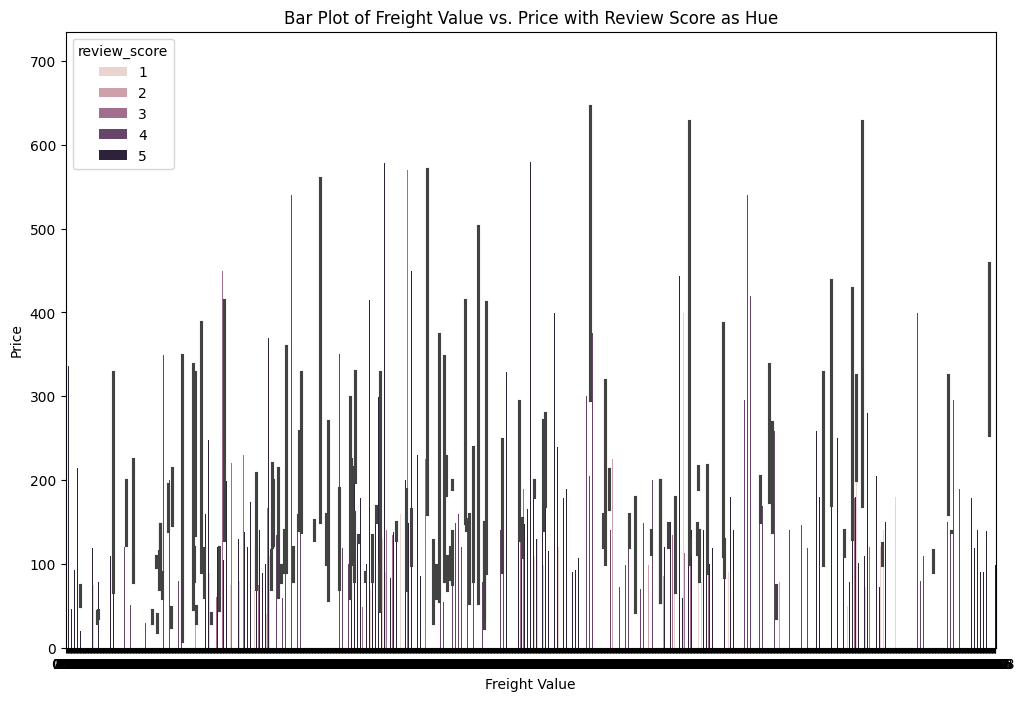

In [42]:
# bar plot matrix
plt.figure(figsize=(12, 8))
sns.barplot(x=cluster_2_data["freight_value"], y=cluster_2_data["price"], hue="review_score", data=cluster_2_data)
plt.title('Bar Plot of Freight Value vs. Price with Review Score as Hue')
plt.xlabel('Freight Value')
plt.ylabel('Price')




*   columns_about_products




Text(0.5, 1.02, 'Pair Plot for Cluster 1 with Review Score as Hue (products)')

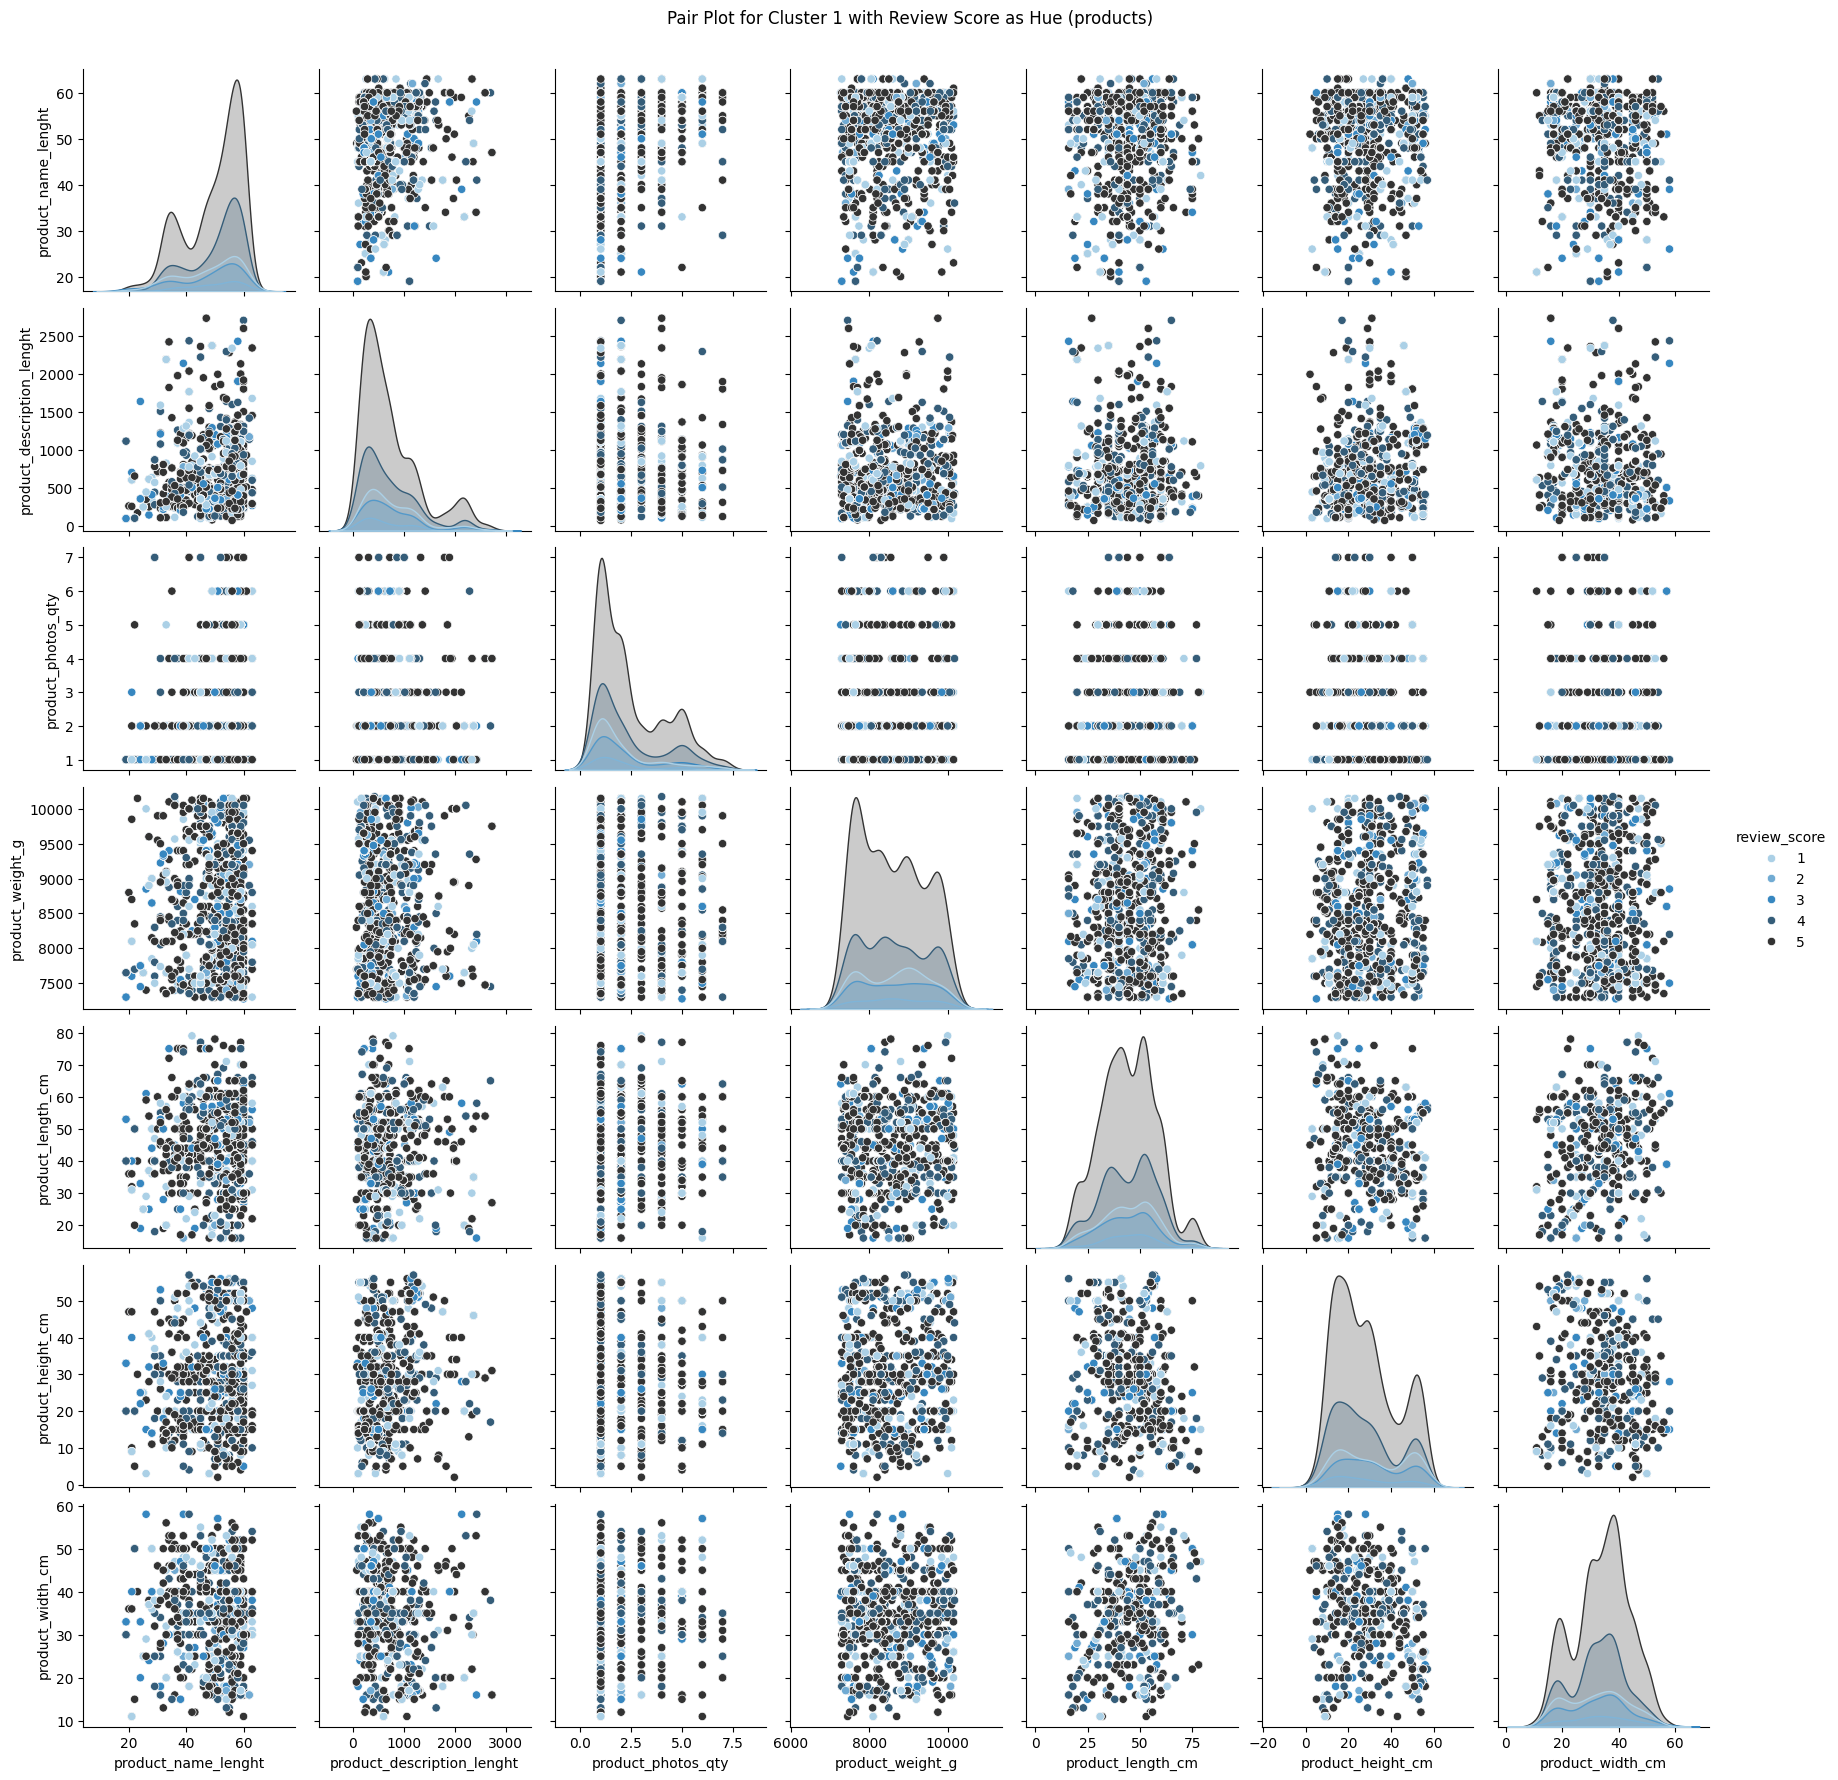

In [43]:
# Filter data for Cluster 1 with selected columns
cluster_2_data_to_plot = cluster_2_data[columns_about_products + ['review_score']]

# Create a pair plot with hue set to 'review_score'
sns.pairplot(cluster_2_data_to_plot, hue='review_score', palette='Blues_d')
plt.suptitle('Pair Plot for Cluster 1 with Review Score as Hue (products)', y=1.02)


Text(0.5, 1.02, 'Scatter Plot Matrix for Cluster 2 with Review Score as Hue (products)')

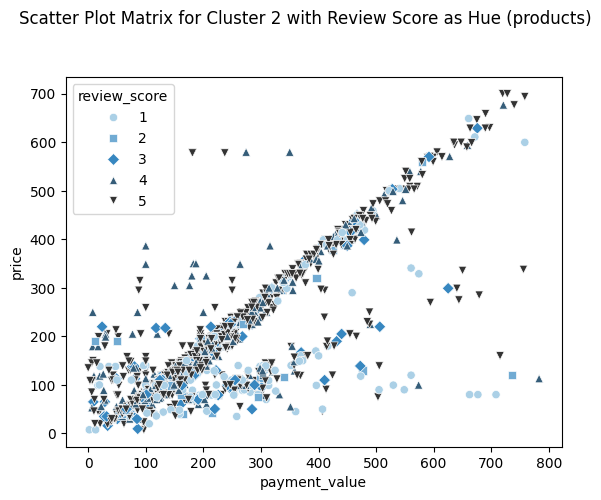

In [44]:
# scatter plot matrix
sns.scatterplot(data=cluster_2_data_to_plot, x=cluster_2_data['payment_value'], y=cluster_2_data['price'], hue='review_score', style='review_score', markers=["o", "s", "D", "^", "v"], palette='Blues_d')
plt.suptitle('Scatter Plot Matrix for Cluster 2 with Review Score as Hue (products)', y=1.02)


# **Step 10: Evaluasi**

# Evaluasi kualitas klaster menggunakan silhouette score

In [45]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [55]:
# Konversikan ke Pandas DataFrame untuk perhitungan skor siluet
pandas_df = predictions.select("features", "prediction").toPandas()

# ekstraksi fitur dan label
X = np.vstack(pandas_df['features'])
labels = pandas_df['prediction'].values

# hitung Silhouette Score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4586040830544361


# **Step 11: Penyempurnaan Berulang (Iterative Refinement)**

melakukan proses analisis secara iteratif untuk menghasilkan model mutahir

# **Step 12: Deploy/Test**

In [48]:
new_df_spark = spark.createDataFrame(data)

# Transformasi data baru dengan pipeline yang telah dilatih
new_transformed_data = pipeline_model.transform(new_df_spark)

# Prediksi kluster dengan model KMeans yang telah dilatih
new_predictions = model.transform(new_transformed_data)

# Menampilkan hasil prediksi
new_predictions.select("customer_id", "payment_value", "prediction").show()

+--------------------+-------------+----------+
|         customer_id|payment_value|prediction|
+--------------------+-------------+----------+
|9ef432eb625129730...|        18.12|         0|
|9ef432eb625129730...|          2.0|         0|
|9ef432eb625129730...|        18.59|         0|
|a20e8105f23924cd0...|        37.77|         0|
|26c7ac168e1433912...|        37.77|         0|
|53904ddbea91e1e92...|        44.09|         0|
|c7340080e39435614...|       356.12|         4|
|388025bec8128ff20...|        267.8|         0|
|388025bec8128ff20...|        267.8|         0|
|388025bec8128ff20...|        267.8|         0|
|388025bec8128ff20...|        267.8|         0|
|388025bec8128ff20...|        267.8|         0|
|96acf11f5c1d5f2dd...|        54.11|         0|
|873967bfecc663740...|        53.11|         0|
|f77c7eef15674a5fd...|       131.23|         0|
|f77c7eef15674a5fd...|       131.23|         2|
|fc8da044983142c6a...|        53.63|         0|
|2c3642e1392097fb4...|       172.14|    

In [49]:
new_predictions.select("customer_id", "review_score", "prediction").show()

+--------------------+------------+----------+
|         customer_id|review_score|prediction|
+--------------------+------------+----------+
|9ef432eb625129730...|           4|         0|
|9ef432eb625129730...|           4|         0|
|9ef432eb625129730...|           4|         0|
|a20e8105f23924cd0...|           4|         0|
|26c7ac168e1433912...|           5|         0|
|53904ddbea91e1e92...|           3|         0|
|c7340080e39435614...|           1|         4|
|388025bec8128ff20...|           1|         0|
|388025bec8128ff20...|           1|         0|
|388025bec8128ff20...|           1|         0|
|388025bec8128ff20...|           1|         0|
|388025bec8128ff20...|           1|         0|
|96acf11f5c1d5f2dd...|           1|         0|
|873967bfecc663740...|           3|         0|
|f77c7eef15674a5fd...|           5|         0|
|f77c7eef15674a5fd...|           5|         2|
|fc8da044983142c6a...|           4|         0|
|2c3642e1392097fb4...|           5|         3|
|d6c5e3efecf1

In [ ]:
# from pyspark.sql import Window
# from pyspark.sql.functions import row_number

# # Ganti "kolom_tertentu" dengan nama kolom yang ingin Anda lihat nilainya
# kolom_tertentu = "payment_value"

# # Definisikan window partitioned by prediction (cluster) dan diurutkan oleh suatu kolom jika diperlukan
# window_spec = Window.partitionBy("prediction")

# # Tambahkan nomor baris untuk setiap partisi (cluster)
# clustered_df = predictions.withColumn("row_num", row_number().over(window_spec))

# # Filter baris pertama dari setiap cluster
# nilai_kolom = clustered_df.filter(clustered_df.row_num == 1).select("prediction", kolom_tertentu)

# # Tampilkan hasilnya
# nilai_kolom.show()
